# Quantify the difference in Complexity Penalty between different Measures

In [1]:
%run imports.py

seed = 4
np.random.seed(seed)
tf.random.set_seed(seed)

All packages loaded successfully.


In [2]:
# --- Generate synthetic 2D data ---
def true_function(X):
    return 0.1*X**2


n = 1000
noise = 0.01
X = np.random.normal(3, 1, size=n)
y = true_function(X) + np.random.normal(0, noise, size=n)

X = X.reshape(-1, 1)
y = y.reshape(-1, 1)


kf = KFold(n_splits=10, shuffle=True, random_state=0)
X_train, X_test, y_train, y_test = None, None, None, None
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    break


y_mean, y_std = np.mean(y_train), np.std(y_train)
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

X_mean = np.mean(X_train)
X_var = np.var(X_train)

In [3]:
print("OAK with a Gaussian Measure N(0,1) ...")
custom_measure = MOGMeasure(means=np.array([0.0]), variances=np.array([1.0]), weights=np.array([1.0]))
gmm_measures_list = [custom_measure]


# --- Create mean three Gaussian measure model ---
data = (X_train, y_train)
model = create_model_oak(
        data=data,
        max_interaction_depth=1,
        constrain_orthogonal=True,
        share_var_across_orders=True,
        use_sparsity_prior=False,
        gmm_measures=gmm_measures_list,
)
model.kernel.kernels[0].base_kernel.variance.assign(1.0)
gpflow.set_trainable(model.kernel.kernels[0].base_kernel.variance, False)


# --- Train model ---
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))


# --- Print model summary ---
gpflow.utilities.print_summary(model)
print(model.training_loss().numpy())

K_model = model.kernel.K(X_train, X_train) + tf.eye(X_train.shape[0], dtype=tf.float64) * model.likelihood.variance.numpy()
alpha_model = tf.linalg.solve(K_model, tf.convert_to_tensor(y_train, dtype=tf.float64))
model_datafit = 0.5 * y_train.T@alpha_model
L_model = tf.linalg.cholesky(K_model)
model_complexity = tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L_model))).numpy()




print("OAK with a Learned Gaussian Measure ...")
custom_measure = MOGMeasure(means=np.array([3]), variances=np.array([1]), weights=np.array([1.0]))
gmm_measures_list = [custom_measure]


# --- Create mean three Gaussian measure model ---
model1 = create_model_oak(
         data=data,
         max_interaction_depth=1,
         constrain_orthogonal=True,
         share_var_across_orders=True,
         use_sparsity_prior=False,
         gmm_measures=gmm_measures_list,
)
model1.kernel.kernels[0].base_kernel.variance.assign(1.0)
gpflow.set_trainable(model1.kernel.kernels[0].base_kernel.variance, False)


# --- Train model ---
opt = gpflow.optimizers.Scipy()
opt.minimize(model1.training_loss, model1.trainable_variables, options=dict(maxiter=1000, gtol=1e-8, ftol=1e-12, disp=True))


# --- Print model summary ---
gpflow.utilities.print_summary(model1)
print(model1.training_loss().numpy())

K_model1 = model1.kernel.K(X_train, X_train) + tf.eye(X_train.shape[0], dtype=tf.float64) * model1.likelihood.variance.numpy()
alpha_model1 = tf.linalg.solve(K_model1, tf.convert_to_tensor(y_train, dtype=tf.float64))
model_datafit1 = 0.5 * y_train.T@alpha_model1
L_model1 = tf.linalg.cholesky(K_model1)
model_complexity1 = tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L_model1))).numpy()

OAK with a Gaussian Measure N(0,1) ...
╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │          value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════╡
│ GPR.kernel.kernels[0].base_kernel.variance     │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │    1           │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────┤
│ GPR.kernel.kernels[0].base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   11.9259      │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼────────────

In [4]:
# --- Verify the Posteriors and Data Fit Terms are identical ---
x_plot = np.linspace(-2, 2, 100).reshape(-1,1)

y_model, _ = model.predict_f(x_plot)
y_model1, _ = model1.predict_f(x_plot)

print(f"MSE is {mean_squared_error(y_model, y_model1)}")

MSE is 9.521932756312389e-07


In [5]:
print(model_datafit.numpy()[0][0], model_datafit1.numpy()[0][0])
print()
print(model_complexity, model_complexity1)

450.0168435448934 450.00003238083576

-3682.043389555928 -3685.472847602232


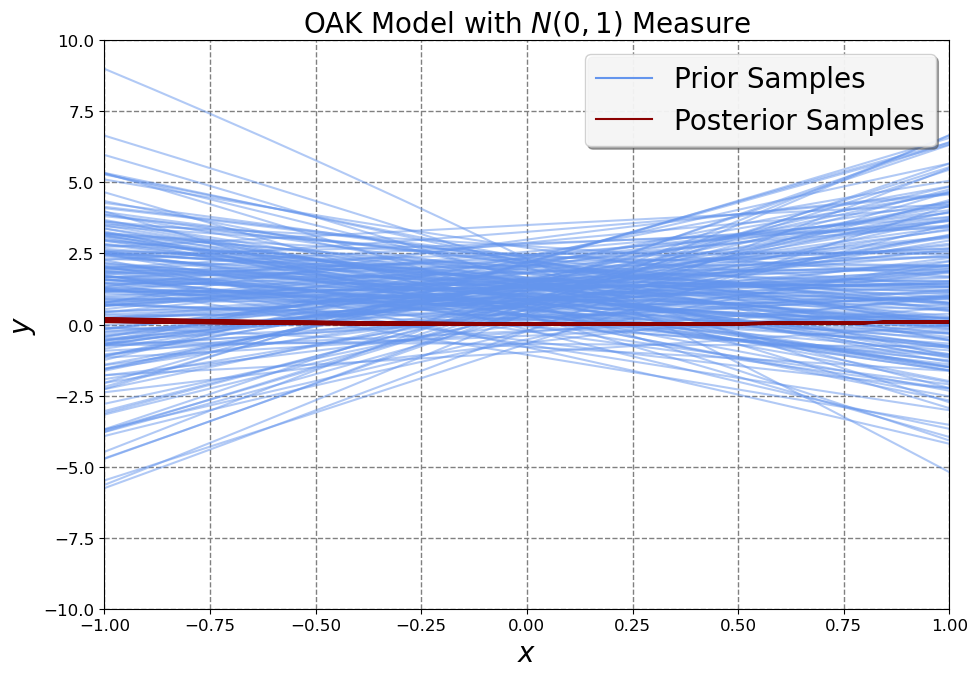

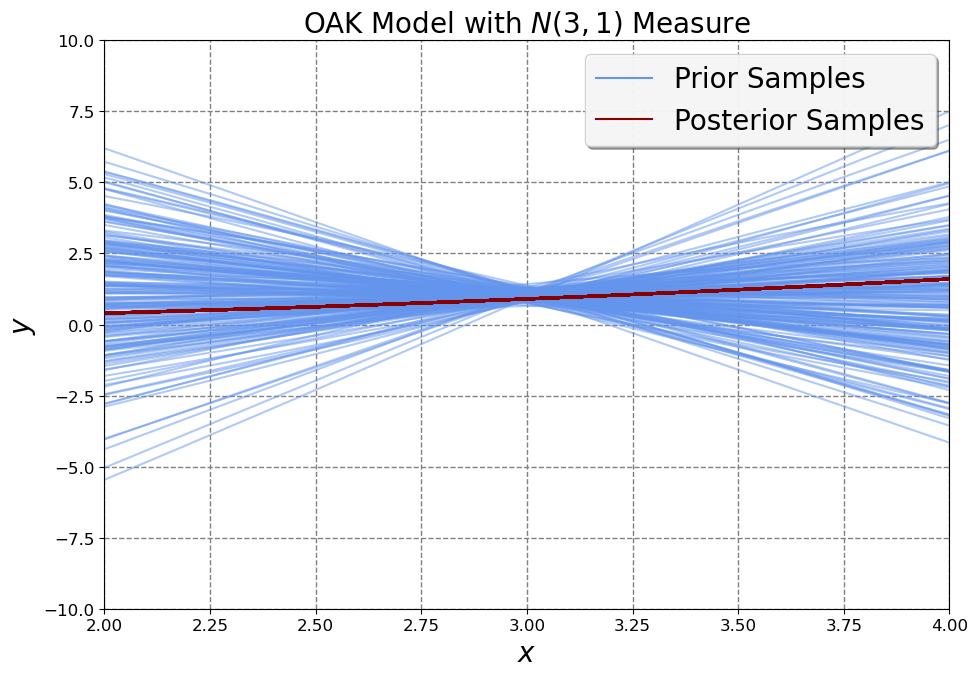

In [6]:
# --- Visualise the difference in function draws from the priors ---
num_samples = 200
num_test_points = 200
plot_range = (-5, 8)

# Create a 1D test data array
X_test = np.linspace(plot_range[0], plot_range[1], num_test_points).reshape(-1, 1)


def plot_prior_vs_posterior_1d(ax, model_to_plot, X_test_data, title, xlabel):

    kernel = model_to_plot.kernel
    K = kernel(X_test_data)
    jitter = 1e-6
    K += jitter * np.eye(num_test_points)
    mean_vector = np.zeros(num_test_points)
    prior_samples = np.random.multivariate_normal(mean_vector, K, size=num_samples)

    posterior_samples = model_to_plot.predict_f_samples(X_test_data, num_samples)[:, :, 0]

    X_data, y_data = model_to_plot.data

    for i in range(num_samples):
        ax.plot(X_test_data.flatten(), prior_samples[i, :] * y_std + y_mean, '-', color='cornflowerblue', lw=1.5, alpha=0.5)
    for i in range(num_samples):
        ax.plot(X_test_data.flatten(), posterior_samples[i, :] * y_std + y_mean, '-', color='darkred', lw=2, alpha=0.5)


    ax.plot([], [], '-', color='cornflowerblue', label='Prior Samples')
    ax.plot([], [], '-', color='darkred', label='Posterior Samples')


    ax.set_title(title, fontsize=20)
    ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True, framealpha=0.9)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=12)


# --- Figure 1: OAK Model with N(0,1) measure ---
fig1, ax1 = plt.subplots(1, 1, figsize=(10, 7))
plot_prior_vs_posterior_1d(ax1, model, X_test, 'OAK Model with $N(0,1)$ Measure', '$x$')
ax1.set_ylim([-10, 10])
ax1.set_xlim([-1,1])
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
plt.tight_layout()
plt.show()


# --- Figure 2: OAK Model with N(3,1) measure ---
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 7))
plot_prior_vs_posterior_1d(ax2, model1, X_test, 'OAK Model with $N(3,1)$ Measure', '$x$')
ax2.set_ylim([-10, 10])
ax2.set_xlim([2,4])
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
plt.tight_layout()
plt.show()